In [6]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')


finwiz_url = 'https://finviz.com/quote.ashx?t='

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/moritzwildenhain/nltk_data...


In [7]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:20.0) Gecko/20100101 Firefox/20.0'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [8]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Best Stock to Buy: Amazon vs. Tesla vs. Palantir
Feb-16-23 06:21PM
Shopify stock suffers one of its worst days yet as Wall Street wonders what is to come
05:34PM
11 High Growth IT Stocks to Buy
04:39PM
Retail investors are pouring a record $1.5 billion per day into the stock market
02:38PM


In [9]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AMZN',
  'Feb-16-23',
  '06:21PM',
  'Best Stock to Buy: Amazon vs. Tesla vs. Palantir'],
 ['AMZN',
  'Feb-16-23',
  '05:34PM',
  'Shopify stock suffers one of its worst days yet as Wall Street wonders what is to come'],
 ['AMZN', 'Feb-16-23', '04:39PM', '11 High Growth IT Stocks to Buy'],
 ['AMZN',
  'Feb-16-23',
  '02:38PM',
  'Retail investors are pouring a record $1.5 billion per day into the stock market'],
 ['AMZN',
  'Feb-16-23',
  '02:00PM',
  "Using Amazon's 'Try Before You Buy' Program? Beware This Pitfall"],
 ['AMZN',
  'Feb-16-23',
  '01:27PM',
  'Investors Are Growing Wary That the FTC Could Try to Block CVS, Amazon Deals'],
 ['AMZN',
  'Feb-16-23',
  '01:22PM',
  'Shopify stock nears record decline as future looks cloudy'],
 ['AMZN',
  'Feb-16-23',
  '01:13PM',
  'Streaming wars: Key takeaways from Netflix, Apple, Paramount and Disney earnings'],
 ['AMZN', 'Feb-16-23', '12:00PM', 'Why Buying in Bulk May Not Work for You'],
 ['AMZN',
  'Feb-16-23',
  '10:56AM',
  'Walma

In [10]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2023-02-16,06:21PM,Best Stock to Buy: Amazon vs. Tesla vs. Palantir,0.000,0.543,0.457,0.7096
1,AMZN,2023-02-16,05:34PM,Shopify stock suffers one of its worst days ye...,0.324,0.676,0.000,-0.8020
2,AMZN,2023-02-16,04:39PM,11 High Growth IT Stocks to Buy,0.000,0.698,0.302,0.3818
3,AMZN,2023-02-16,02:38PM,Retail investors are pouring a record $1.5 bil...,0.000,1.000,0.000,0.0000
4,AMZN,2023-02-16,02:00PM,Using Amazon's 'Try Before You Buy' Program? B...,0.000,1.000,0.000,0.0000


/var/folders/yk/f2s_9trx6fzbx95hxnpg7m580000gn/T/ipykernel_84495/1045310283.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()


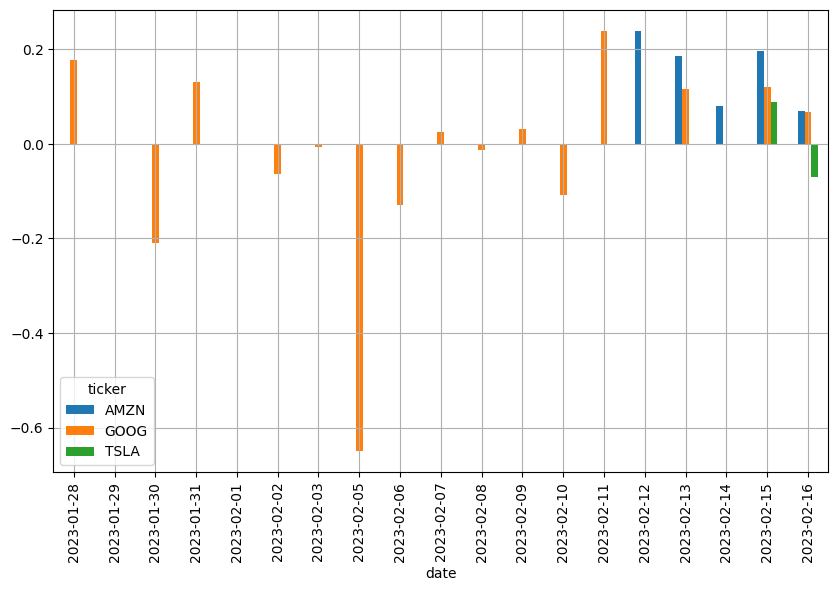

In [11]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()